In [14]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import random
import seaborn as sns
import itertools as it
import pulp
from sklearn.cluster import KMeans
import time
from multiprocessing import Pool


sys.path.append(os.path.join(os.getcwd(), 'code'))
from spatial_generation import Spatial, GroupSpatial
from elections import SNTV,Bloc,STV,Borda, ChamberlinCourant, Monroe, GreedyCC, PluralityVeto, SMRD, OMRD, DMRD, ExpandingApprovals
from tools import cost, best_group_cost, worst_group_cost, remove_candidates, borda_matrix, group_representation, max_group_representation, qmin
from election_sampling import election_sample, samples

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# Colors!
pal = sns.color_palette("hls", 8)
tab20_colors = plt.cm.tab20.colors

# Group Representation

In [6]:
# Choose number of voters n
# And the number of candidates m
n = 100
m = 20

# And the number of winners for the election
k = 4

#### 2 Party

In [7]:
# Means for each of the 4 Gaussian distributions
means = [[0, -2], [0, 2]]
stds = [0.5, 0.5]  # Standard deviations for each Gaussian
two_party_G = [50,50]  # Group Sizes

voter_params = [{'loc': None, 'scale': None, 'size': 2} for _ in range(len(two_party_G))]
for i,mean in enumerate(means):
    voter_params[i]['loc'] = mean

for i,std in enumerate(stds):
    voter_params[i]['scale'] = std
    
candidate_params = {'low': -5, 'high': 5, 'size': 2}

distance = lambda point1, point2: np.linalg.norm(point1 - point2)

two_party_generator = GroupSpatial(m = m, g = len(two_party_G),
                    voter_dists = [np.random.normal]*len(two_party_G), voter_params = voter_params,
                    candidate_dist = np.random.uniform, candidate_params = candidate_params,
                    distance = distance)

In [8]:
# Generate a profile from random candidate and voter positions
profile, candidate_positions, voter_positions, voter_labels = two_party_generator.generate(two_party_G)

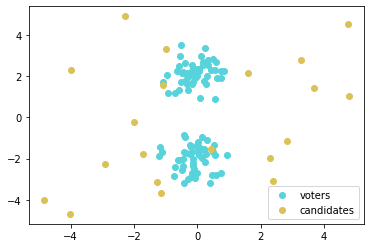

In [9]:
# visualize the results
pal = sns.color_palette("hls", 8)
plt.scatter(voter_positions[:,0], voter_positions[:,1], label = 'voters', color = pal[4])
plt.scatter(candidate_positions[:,0], candidate_positions[:,1], label = 'candidates', color = pal[1])
plt.legend()

### 4 Party

In [34]:
# Means for each of the 4 Gaussian distributions
means = [[-2, 0], [2, 0], [0, 2], [0, -2]]
stds = [0.5, 0.5, 0.5, 0.5]  # Standard deviations for each Gaussian
four_party_G = [25, 25, 25, 25]  # Group Sizes

voter_params = [{'loc': None, 'scale': None, 'size': 2} for _ in range(len(four_party_G))]
for i,mean in enumerate(means):
    voter_params[i]['loc'] = mean

for i,std in enumerate(stds):
    voter_params[i]['scale'] = std
    
candidate_params = {'low': -3, 'high': 3, 'size': 2}

distance = lambda point1, point2: np.linalg.norm(point1 - point2)

four_party_generator = GroupSpatial(m = m, g = len(four_party_G),
                    voter_dists = [np.random.normal]*len(four_party_G), voter_params = voter_params,
                    candidate_dist = np.random.uniform, candidate_params = candidate_params,
                    distance = distance)

In [35]:
# Generate a profile from random candidate and voter positions
profile, candidate_positions, voter_positions, voter_labels = four_party_generator.generate(four_party_G)

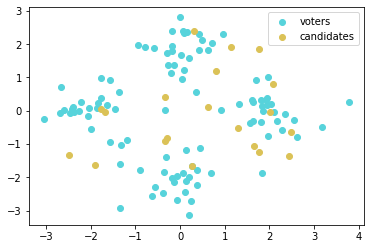

In [36]:
# visualize the results
pal = sns.color_palette("hls", 8)
plt.scatter(voter_positions[:,0], voter_positions[:,1], label = 'voters', color = pal[4])
plt.scatter(candidate_positions[:,0], candidate_positions[:,1], label = 'candidates', color = pal[1])
plt.legend()

### Elections

In [10]:
elections_dict = {SNTV:{}, Bloc:{}, STV:{},
                 Borda:{}, ChamberlinCourant:{}, GreedyCC:{}, Monroe:{}, PluralityVeto:{},
                 SMRD:{}, OMRD:{}, DMRD:{'rho': 0.5}, ExpandingApprovals: {}}
elections_list = [SNTV, Bloc, STV, Borda, ChamberlinCourant, GreedyCC, Monroe, 
                  PluralityVeto, ExpandingApprovals, SMRD, OMRD, DMRD]

'''
elections_dict = {SNTV:{}, Bloc:{}, STV:{},
                 Borda:{},GreedyCC:{}, PluralityVeto:{},
                 SMRD:{}, OMRD:{}, DMRD:{'rho': 0.5}}
elections_list = [SNTV, Bloc, STV, Borda, ChamberlinCourant, GreedyCC, Monroe,
                  PluralityVeto, SMRD, OMRD, DMRD]
'''

n_samples = 10000

In [11]:
'''
#f = 'data/2party.npz'
start = time.time()
results_list = samples(n_samples, two_party_generator, elections_dict, [two_party_G], k, dim = 2, filename = None)
end = time.time()
print(end - start)
result_dict = results_list[0]
'''


f = 'data/2bloc.npz'
loaded_data = np.load(f)
result_dict = {key: loaded_data[key] for key in loaded_data.files}

### Distribution Plot

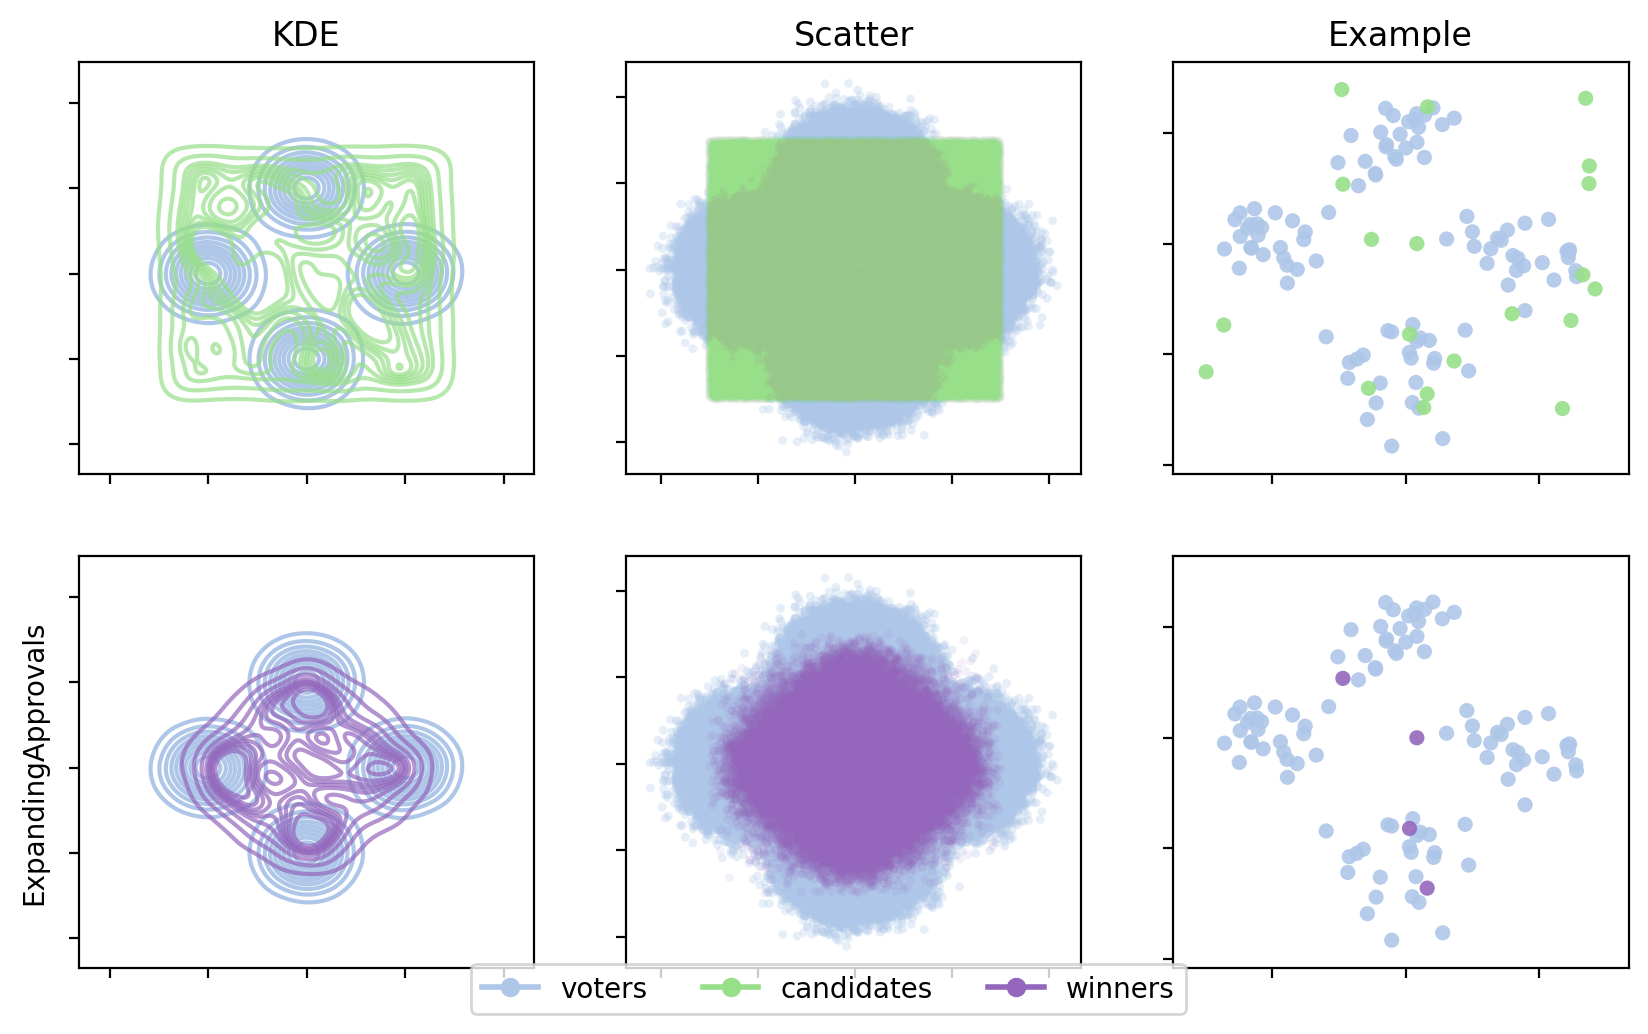

In [51]:
fig, axes = plt.subplots(len(elections_list) + 1, 3, figsize=(10, 6), dpi = 200)

for i, ax in enumerate(axes.flat):
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlabel('')
    ax.set_ylabel('')

#vc = pal[5]
#cc = pal[4]
#wc = pal[7]

vc = tab20_colors[1]
cc = tab20_colors[5]
wc = tab20_colors[8]

# Index for the sample used for the example plots:
sample_idx = 1
voter_example = result_dict['voters'][sample_idx]
voter_stack = pd.DataFrame(np.vstack(result_dict['voters']), columns = ['x','y'])
# Use a smaller sample for KDE plots (otherwise takes a while to run without much added benefit)
voter_stack_sample = voter_stack.sample(frac=0.1, random_state=42)

# Just showing the distribution without the election
candidate_example = result_dict['candidates'][sample_idx]
candidate_stack = pd.DataFrame(np.vstack(result_dict['candidates']), columns = ['x','y'])
# Use a smaller sample for KDE plots (otherwise takes a while to run without much added benefit)
candidate_stack_sample = candidate_stack.sample(frac=0.1, random_state=42)

# Set x and y limits for scatter and example plots:
epsilon = 0.5
scatter_xlim = [min(voter_stack.iloc[:,0].min(), candidate_stack.iloc[:,0].min()) - epsilon,
                max(voter_stack.iloc[:,0].max(), candidate_stack.iloc[:,0].max()) + epsilon]
scatter_ylim = [min(voter_stack.iloc[:,1].min(), candidate_stack.iloc[:,1].min()) - epsilon,
                max(voter_stack.iloc[:,1].max(), candidate_stack.iloc[:,1].max()) + epsilon]

example_xlim = [min(np.min(voter_example[:,0]), np.min(candidate_example[:,0])) - epsilon,
                max(np.max(voter_example[:,0]), np.max(candidate_example[:,0])) + epsilon]
example_ylim = [min(np.min(voter_example[:,1]), np.min(candidate_example[:,1])) - epsilon,
                max(np.max(voter_example[:,1]), np.max(candidate_example[:,1])) + epsilon]


sns.kdeplot(data=voter_stack_sample, x='x', y='y', color = vc, fill=False,
            thresh=0.1, levels=10, alpha = 1, ax = axes[0][0])
sns.kdeplot(data=candidate_stack_sample, x='x', y='y', color = cc, fill=False,
            thresh=0.1, levels=10, alpha = 0.7, ax = axes[0][0])
axes[0][0].set_title('KDE')
axes[0][0].set_ylabel('')
axes[0][0].set_xlabel('')


axes[0][1].scatter(voter_stack.iloc[:,0], voter_stack.iloc[:,1],
                   facecolors = vc, edgecolors = 'none', alpha = 0.3, s = 10)
axes[0][1].scatter(candidate_stack.iloc[:,0], candidate_stack.iloc[:,1],
                   facecolors = cc, edgecolors = 'none', alpha = 0.01, s = 10)
axes[0][1].set_xlim(scatter_xlim)
axes[0][1].set_ylim(scatter_ylim)
axes[0][1].set_title('Scatter')


axes[0][2].scatter(voter_example[:,0], voter_example[:,1],
                   facecolors = vc, edgecolors = 'none', alpha = 0.9, s = 30)
axes[0][2].scatter(candidate_example[:,0], candidate_example[:,1],
                   facecolors = cc, edgecolors = 'none', alpha = 0.9, s = 30)
axes[0][2].set_xlim(example_xlim)
axes[0][2].set_ylim(example_ylim)
axes[0][2].set_title('Example')


for i,E in enumerate(elections_list):
    name = E.__name__
    name_label = name
    if name == 'ChamberlinCourant':
        name_label = 'Chamberlin'
        
    ax_idx = i + 1

    winner_example = result_dict[name][sample_idx]
    winner_stack = pd.DataFrame(np.vstack(result_dict[name]), columns = ['x','y'])
    # Use a smaller sample for KDE plots (otherwise takes a while to run without much added benefit)
    winner_stack_sample = winner_stack.sample(frac=0.1, random_state=42)
    
    sns.kdeplot(data=voter_stack_sample, x='x', y='y', color = vc, fill=False,
                thresh=0.1, levels=10, alpha = 1, ax = axes[ax_idx][0])
    sns.kdeplot(data=winner_stack_sample, x='x', y='y', color = wc, fill=False,
                thresh=0.1, levels=10, alpha = 0.7, ax = axes[ax_idx][0])
    axes[ax_idx][0].set_ylabel(name_label)
    axes[ax_idx][0].set_xlabel('')
    
    axes[ax_idx][1].scatter(voter_stack.iloc[:,0], voter_stack.iloc[:,1],
                   facecolors = vc, edgecolors = 'none', alpha = 0.3, s = 10)
    axes[ax_idx][1].scatter(winner_stack.iloc[:,0], winner_stack.iloc[:,1],
                       facecolors = wc, edgecolors = 'none', alpha = 0.1, s = 10)
    axes[ax_idx][1].set_xlim(scatter_xlim)
    axes[ax_idx][1].set_ylim(scatter_ylim)

    axes[ax_idx][2].scatter(voter_example[:,0], voter_example[:,1],
                       facecolors = vc, edgecolors = 'none', alpha = 0.9, s = 30)
    axes[ax_idx][2].scatter(winner_example[:,0], winner_example[:,1],
                       facecolors = wc, edgecolors = 'none', alpha = 0.9, s = 30)
    axes[ax_idx][2].set_xlim(example_xlim)
    axes[ax_idx][2].set_ylim(example_ylim)
     

legend_elements = [Line2D([0], [0], marker = 'o', color=vc, lw=2, label='voters'),
                   Line2D([0], [0], marker = 'o', color=cc, lw=2, label='candidates'),
                  Line2D([0], [0], marker = 'o', color=wc, lw=2, label='winners')]

fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, 0.075), ncol=3)

### Representation Measures

In [12]:
avg_represent = {e.__name__:np.zeros(n_samples) for e in elections_list}

group_select = 0
for i in range(n_samples):
    voter_positions = result_dict['voters'][i]
    candidate_positions = result_dict['candidates'][i]
    labels = result_dict['labels'][i]
    
    for j,E in enumerate(elections_list):
        name = E.__name__
        winners = result_dict[name][i]
        represent = group_representation(voter_positions, candidate_positions, labels, winners, group_select, size = None)
        avg_represent[name][i] = represent
        
represent_data = [values for values in avg_represent.values()]
represent_labels = [name for name in avg_represent.keys()]

# 2) Treat everyone as one group
avg_represent_overall = {e.__name__:np.zeros(n_samples) for e in elections_list}

group_select = 0
for i in range(n_samples):
    voter_positions = result_dict['voters'][i]
    candidate_positions = result_dict['candidates'][i]
    labels = result_dict['labels'][i]
    labels = np.zeros(len(labels))
    
    for j,E in enumerate(elections_list):
        name = E.__name__
        winners = result_dict[name][i]
        represent = group_representation(voter_positions, candidate_positions, labels, winners, group_select, size = None)
        avg_represent_overall[name][i] = represent
        
represent_data_overall = [values for values in avg_represent_overall.values()]
represent_labels_overall = [name for name in avg_represent_overall.keys()]

ylimit = max(max([np.max(r) for r in represent_data]), max([np.max(r) for r in represent_data_overall]))

represent_labels = ['Chamberlin' if n == 'ChamberlinCourant' else n for n in represent_labels]
represent_labels_overall = ['Chamberlin' if n == 'ChamberlinCourant' else n for n in represent_labels_overall]

Text(0, 0.5, '$\\alpha$')

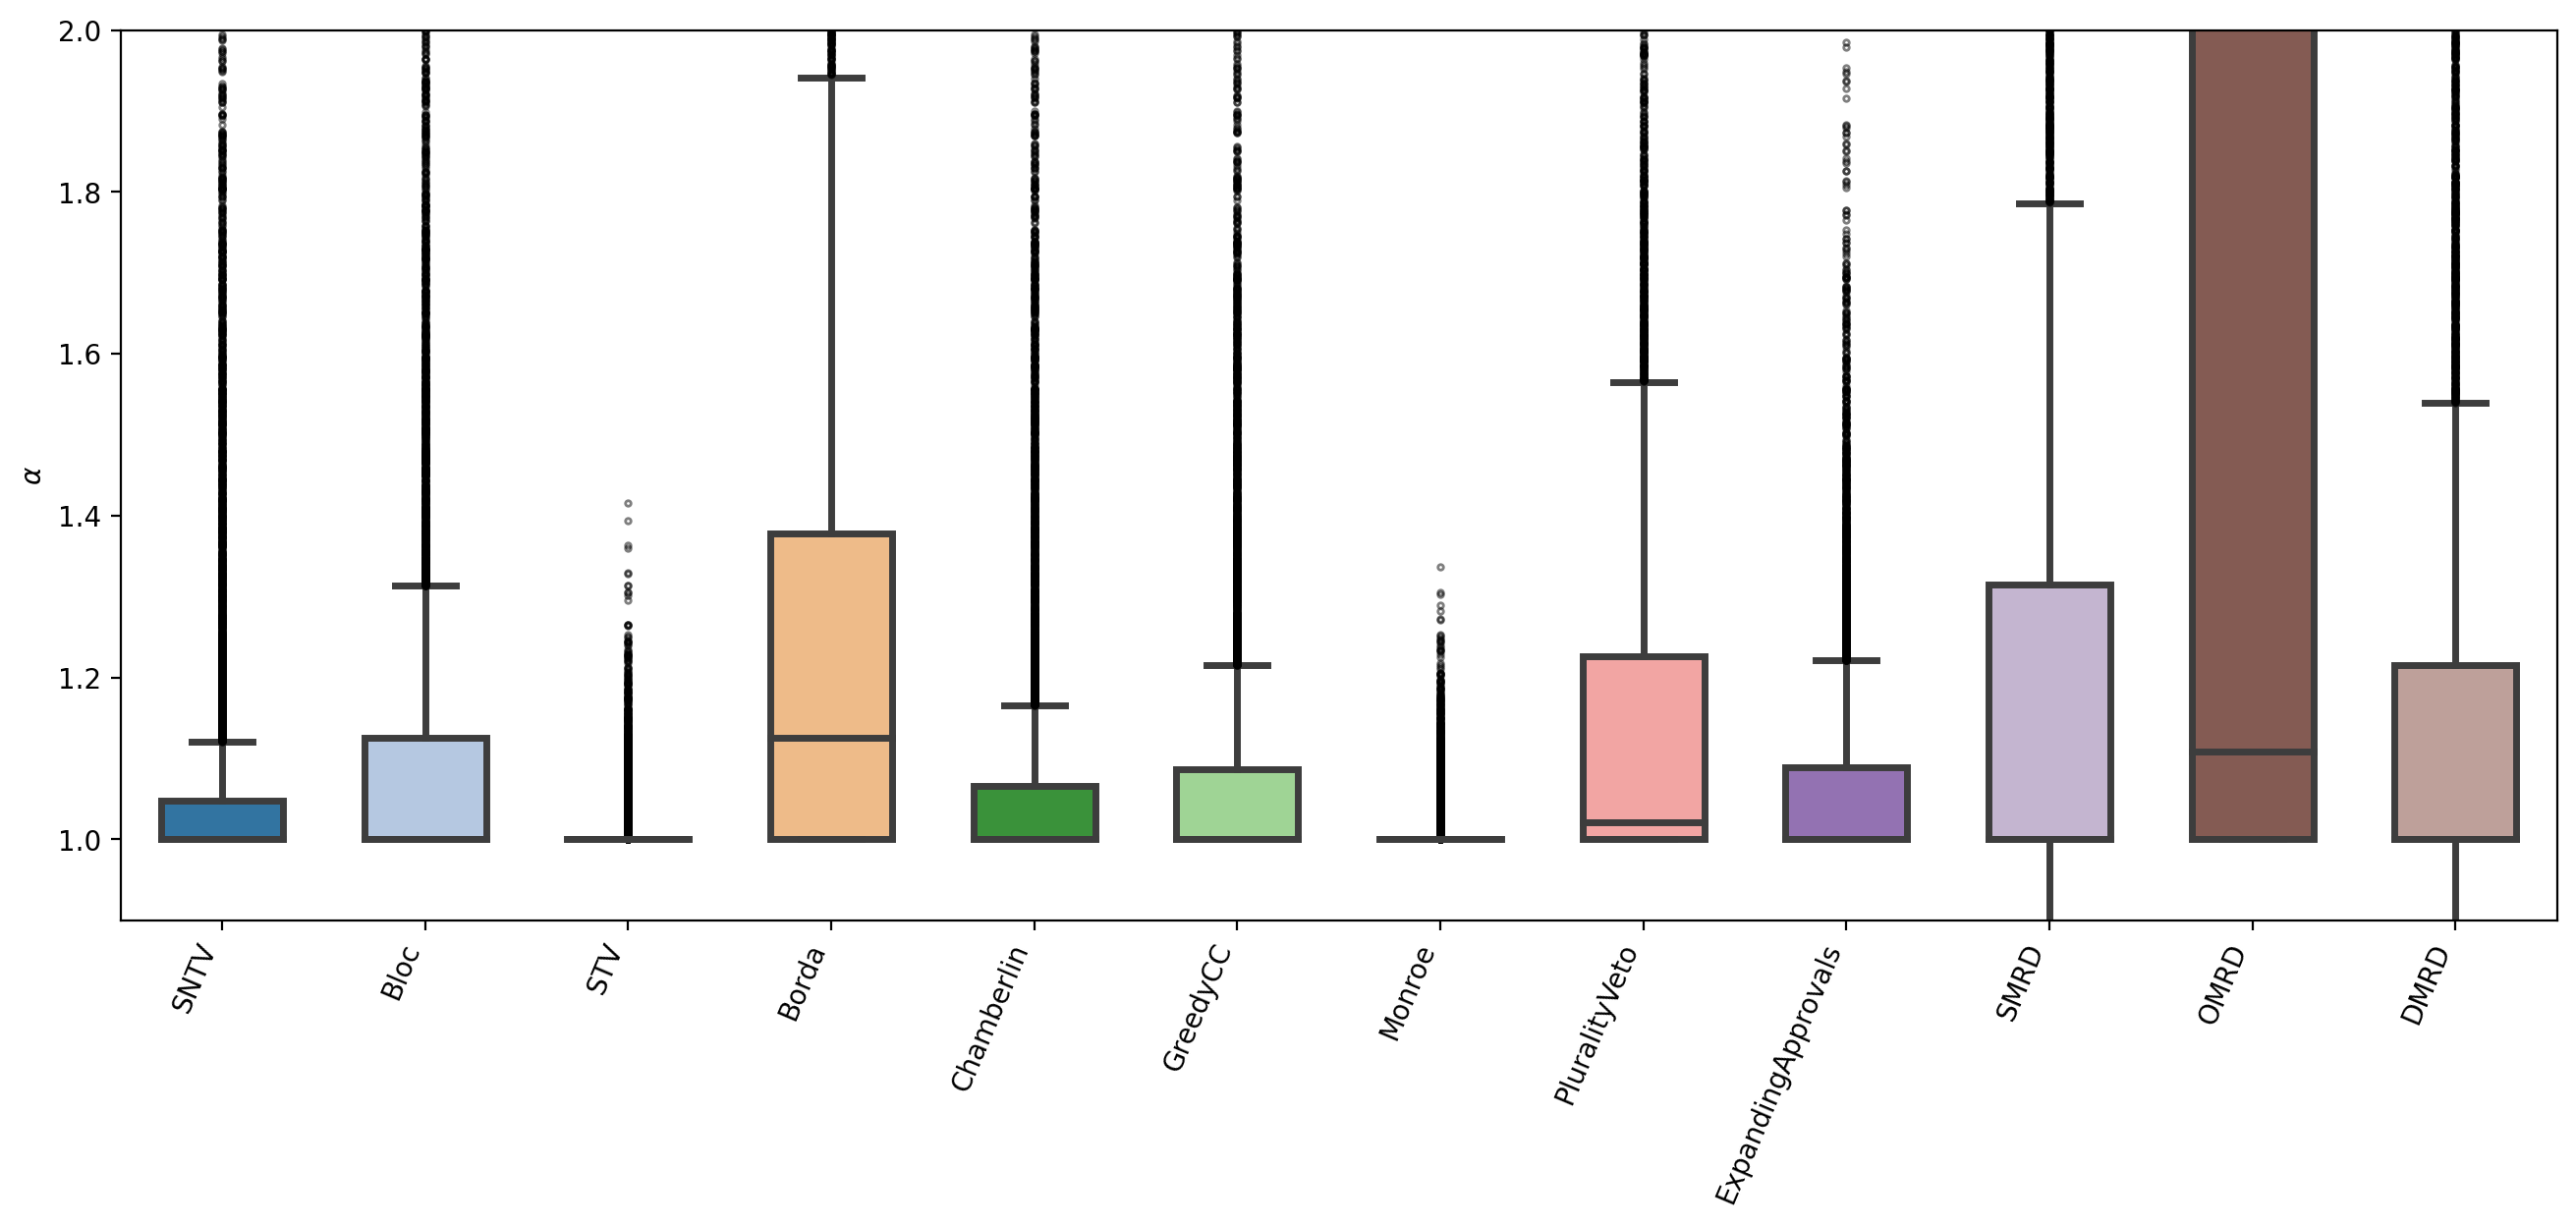

In [13]:
plt.figure(figsize=(16, 6), dpi = 200)
#ax = sns.boxplot(data=represent_data, palette = tab20_colors, alpha = 1, width = 0.9)
#for violin in ax.collections:
#    violin.set_alpha(1)
flierprops = dict(marker='o', markerfacecolor='none', markersize=2, linestyle='none', markeredgecolor='black', alpha = 0.5)

ax = sns.boxplot(data=represent_data, palette = tab20_colors, width = 0.6, linewidth=2.5, fliersize= 1, flierprops=flierprops)
ax.set_ylim(0.9, 2)
plt.xticks(ticks=np.arange(len(elections_list)), labels=represent_labels, rotation=67, ha='right')
plt.ylabel(r'$\alpha$')
#plt.savefig(output_file1, bbox_inches='tight')

Text(0, 0.5, '$\\alpha$')

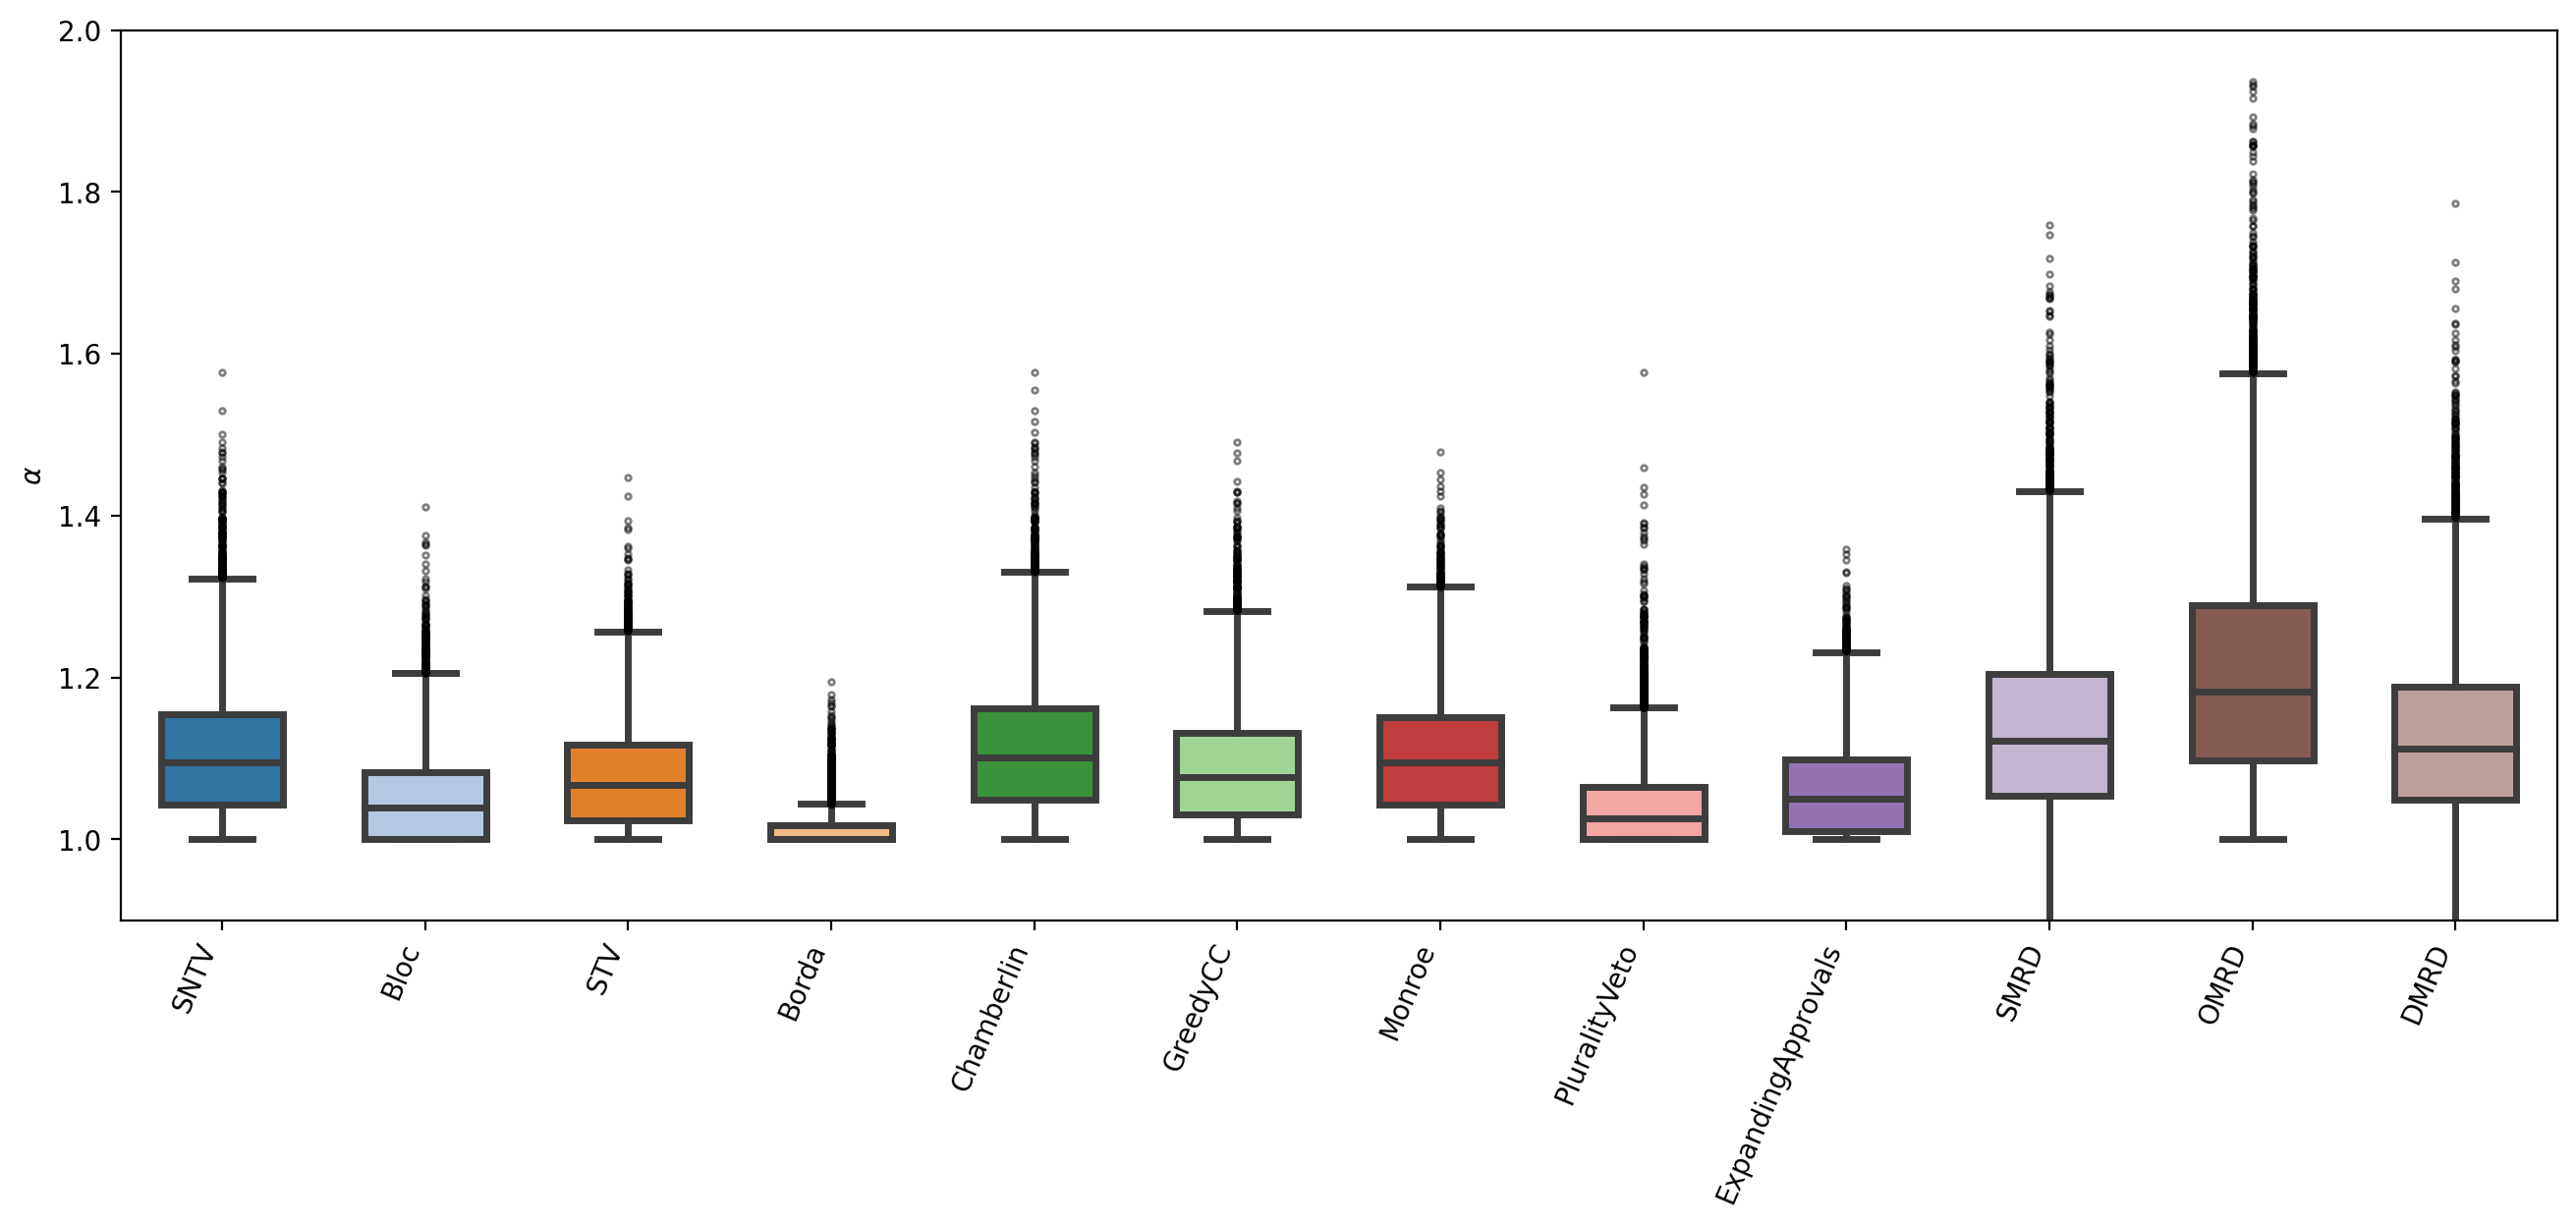

In [81]:
plt.figure(figsize=(16, 6), dpi = 200)
#ax = sns.violinplot(data=represent_data_overall, palette = tab20_colors, alpha = 1, width = 0.9)
#for violin in ax.collections:
#    violin.set_alpha(1)
    
flierprops = dict(marker='o', markerfacecolor='none', markersize=2, linestyle='none', markeredgecolor='black', alpha = 0.5)

ax = sns.boxplot(data=represent_data_overall, palette = tab20_colors, width = 0.6, linewidth=2.5, fliersize= 1, flierprops=flierprops)
ax.set_ylim(0.9, 2)
plt.xticks(ticks=np.arange(len(elections_list)), labels=represent_labels_overall, rotation=67, ha='right')
plt.ylabel(r'$\alpha$')
#plt.savefig(output_file2, bbox_inches='tight')

In [18]:
qmin_samples = {e.__name__:np.zeros(n_samples) for e in elections_list}

for i in range(n_samples):
    voter_positions = result_dict['voters'][i]
    candidate_positions = result_dict['candidates'][i]
    labels = result_dict['labels'][i]
    
    for j,E in enumerate(elections_list):
        name = E.__name__
        winners = result_dict[name][i]
        qmin_sum = qmin(voter_positions, winners, q = 1)
        qmin_samples[name][i] = qmin_sum
        
qmin_data = [values for values in qmin_samples.values()]
qmin_labels = [name for name in qmin_samples.keys()]

Text(0, 0.5, '$\\alpha$')

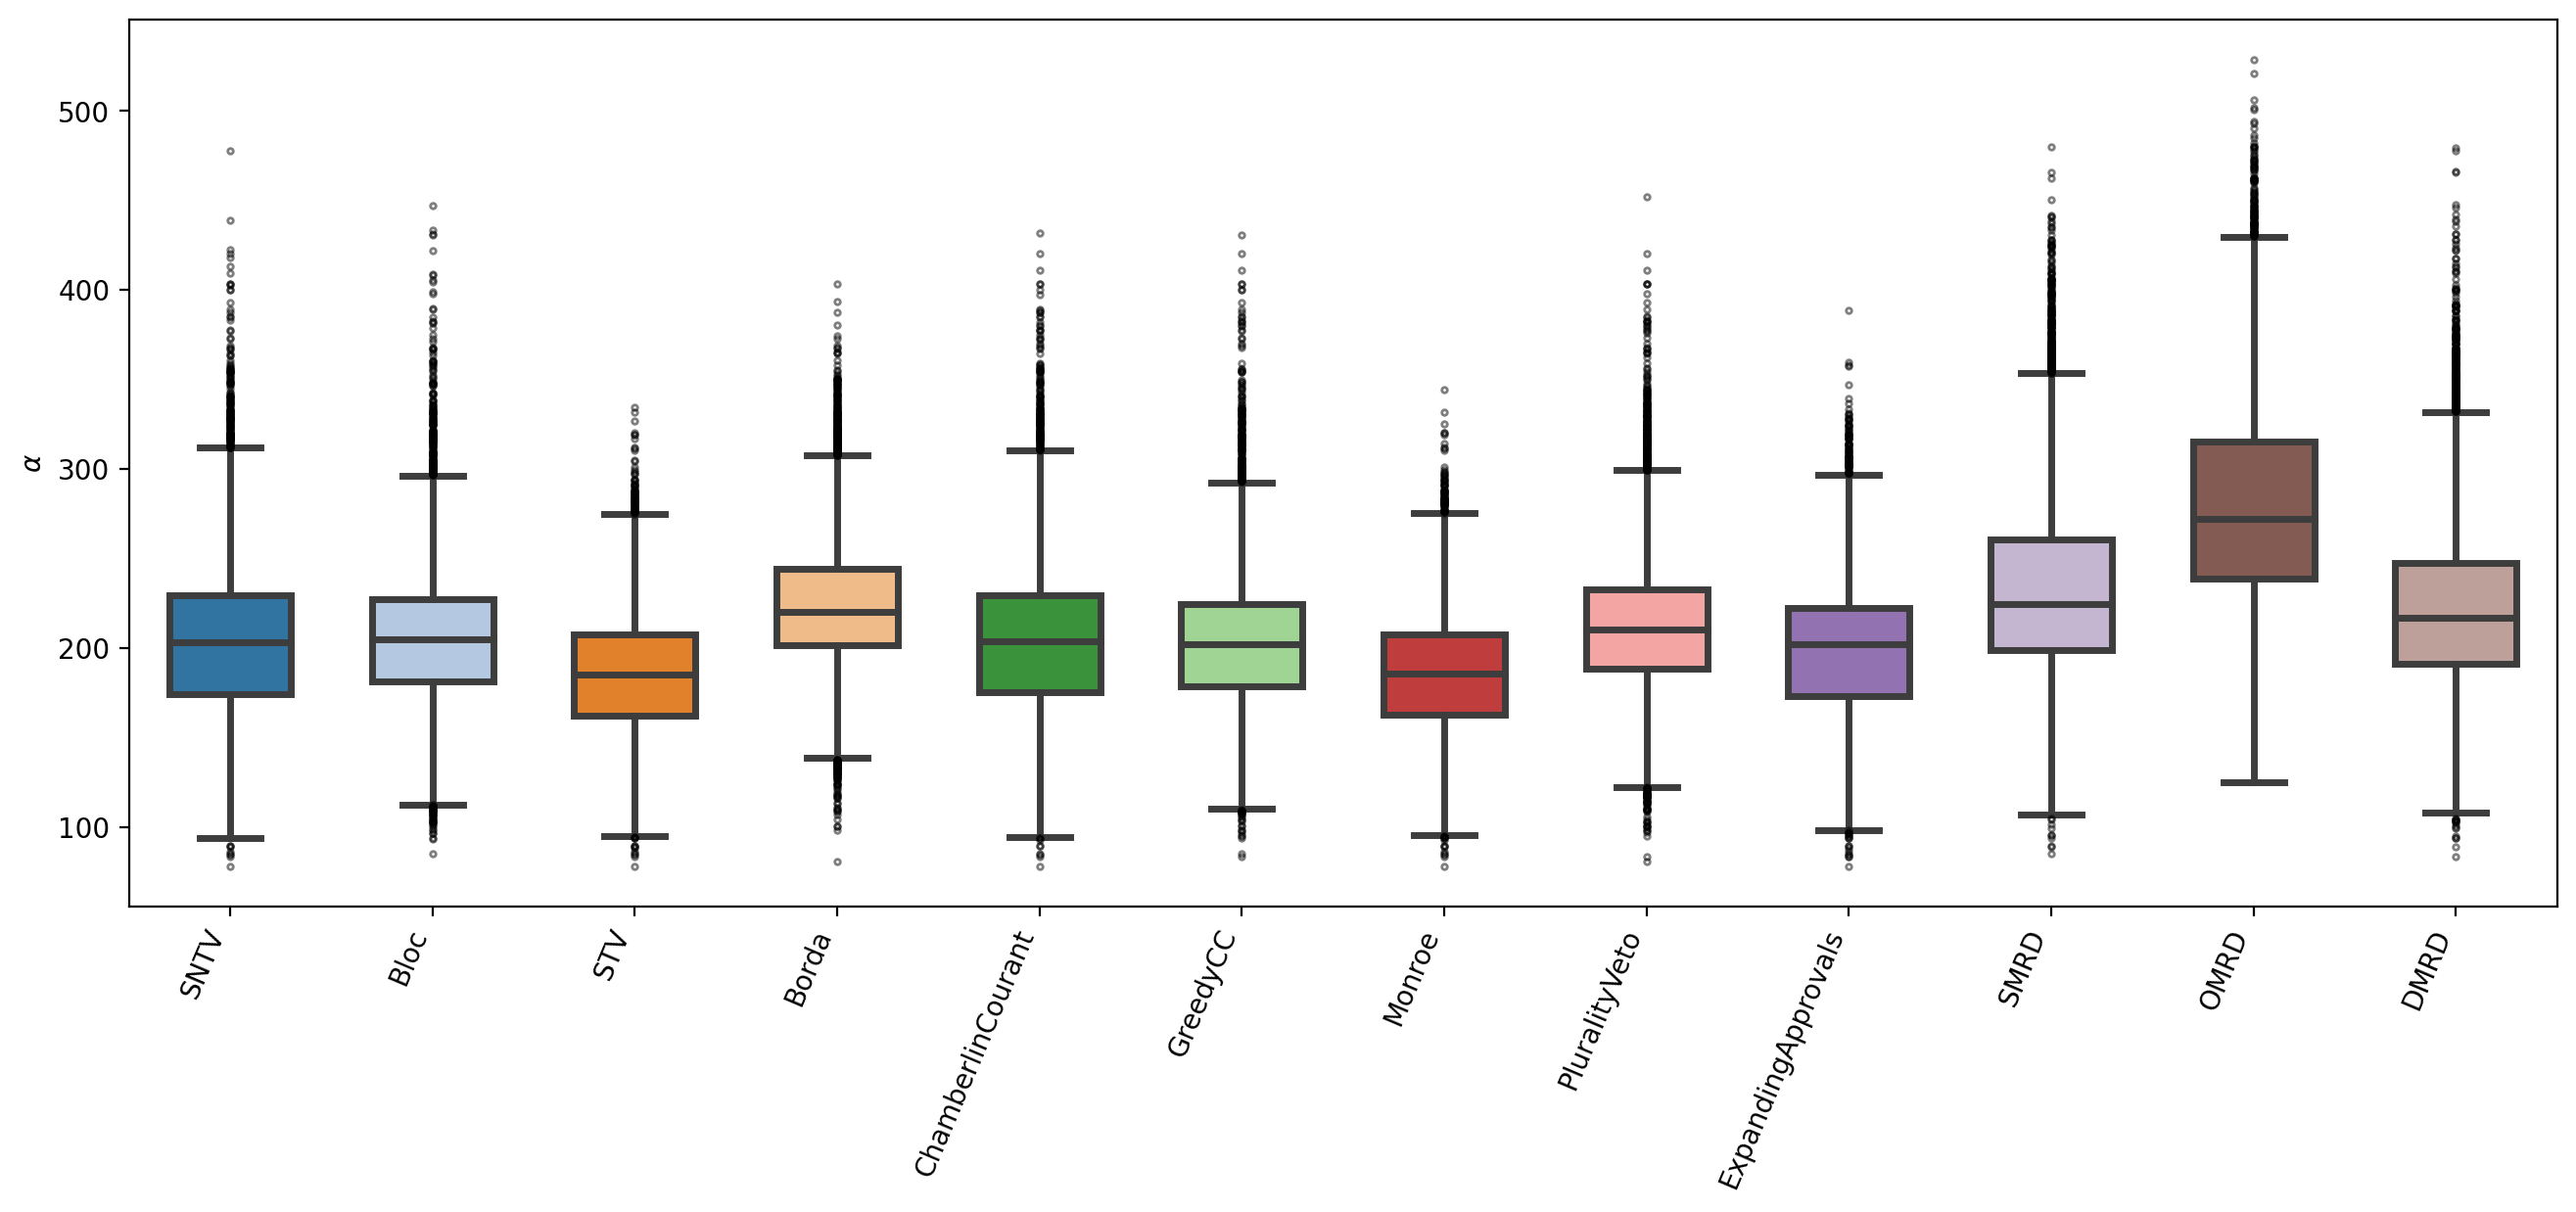

In [24]:
plt.figure(figsize=(16, 6), dpi = 200)
flierprops = dict(marker='o', markerfacecolor='none', markersize=2, linestyle='none', markeredgecolor='black', alpha = 0.5)

ax = sns.boxplot(data=qmin_data, palette = tab20_colors, width = 0.6, linewidth=2.5, fliersize= 1, flierprops=flierprops)
#ax.set_ylim(0.9, 2)
plt.xticks(ticks=np.arange(len(elections_list)), labels=qmin_labels, rotation=67, ha='right')
plt.ylabel(r'$\alpha$')

### Changing Group Sizes

In [55]:
elections_dict = {SNTV:{}, Bloc:{}, STV:{},
                 Borda:{},GreedyCC:{}, PluralityVeto:{},
                 SMRD:{}, OMRD:{}, DMRD:{'rho': 0.5}}
elections_list = [SNTV, Bloc, STV, Borda, ChamberlinCourant, GreedyCC, Monroe,
                  PluralityVeto, SMRD, OMRD, DMRD]

n_samples = 1000

In [63]:
group_sizes = [[100 - i, i] for i in range(0, 105, 5)]
group_select = 1
num_sizes = len(group_sizes)

size_avg_represent = {e.__name__:(np.zeros(num_sizes), np.zeros(num_sizes)) for e in elections_list}
size_avg_represent1 = {e.__name__:(np.zeros(num_sizes), np.zeros(num_sizes)) for e in elections_list}

for s in range(num_sizes):
    f = 'data/2sizes' + str(s) + '.npz'
    loaded_data = np.load(f)
    result_dict = {key: loaded_data[key] for key in loaded_data.files}
    
    s_avg_represent = {e.__name__:np.zeros(n_samples) for e in elections_list}
    s_avg_represent1 = {e.__name__:np.zeros(n_samples) for e in elections_list}
    
    for i in range(n_samples):
        voter_positions = result_dict['voters'][i]
        candidate_positions = result_dict['candidates'][i]
        labels = result_dict['labels'][i]
        labels1 = np.zeros(len(labels))

        for j,E in enumerate(elections_list):
            name = E.__name__
                
            winners = result_dict[name][i]
            represent = group_representation(voter_positions, candidate_positions, labels, winners, group_select, size = None)
            represent1 = group_representation(voter_positions, candidate_positions, labels1, winners, 0, size = None)
            s_avg_represent[name][i] = represent
            s_avg_represent1[name][i] = represent1
            
    for ename, evals in s_avg_represent.items():
        size_avg_represent[ename][0][s] = np.mean(evals)
        size_avg_represent[ename][1][s] = np.std(evals)
        
    for ename, evals in s_avg_represent1.items():
        size_avg_represent1[ename][0][s] = np.mean(evals)
        size_avg_represent1[ename][1][s] = np.std(evals)

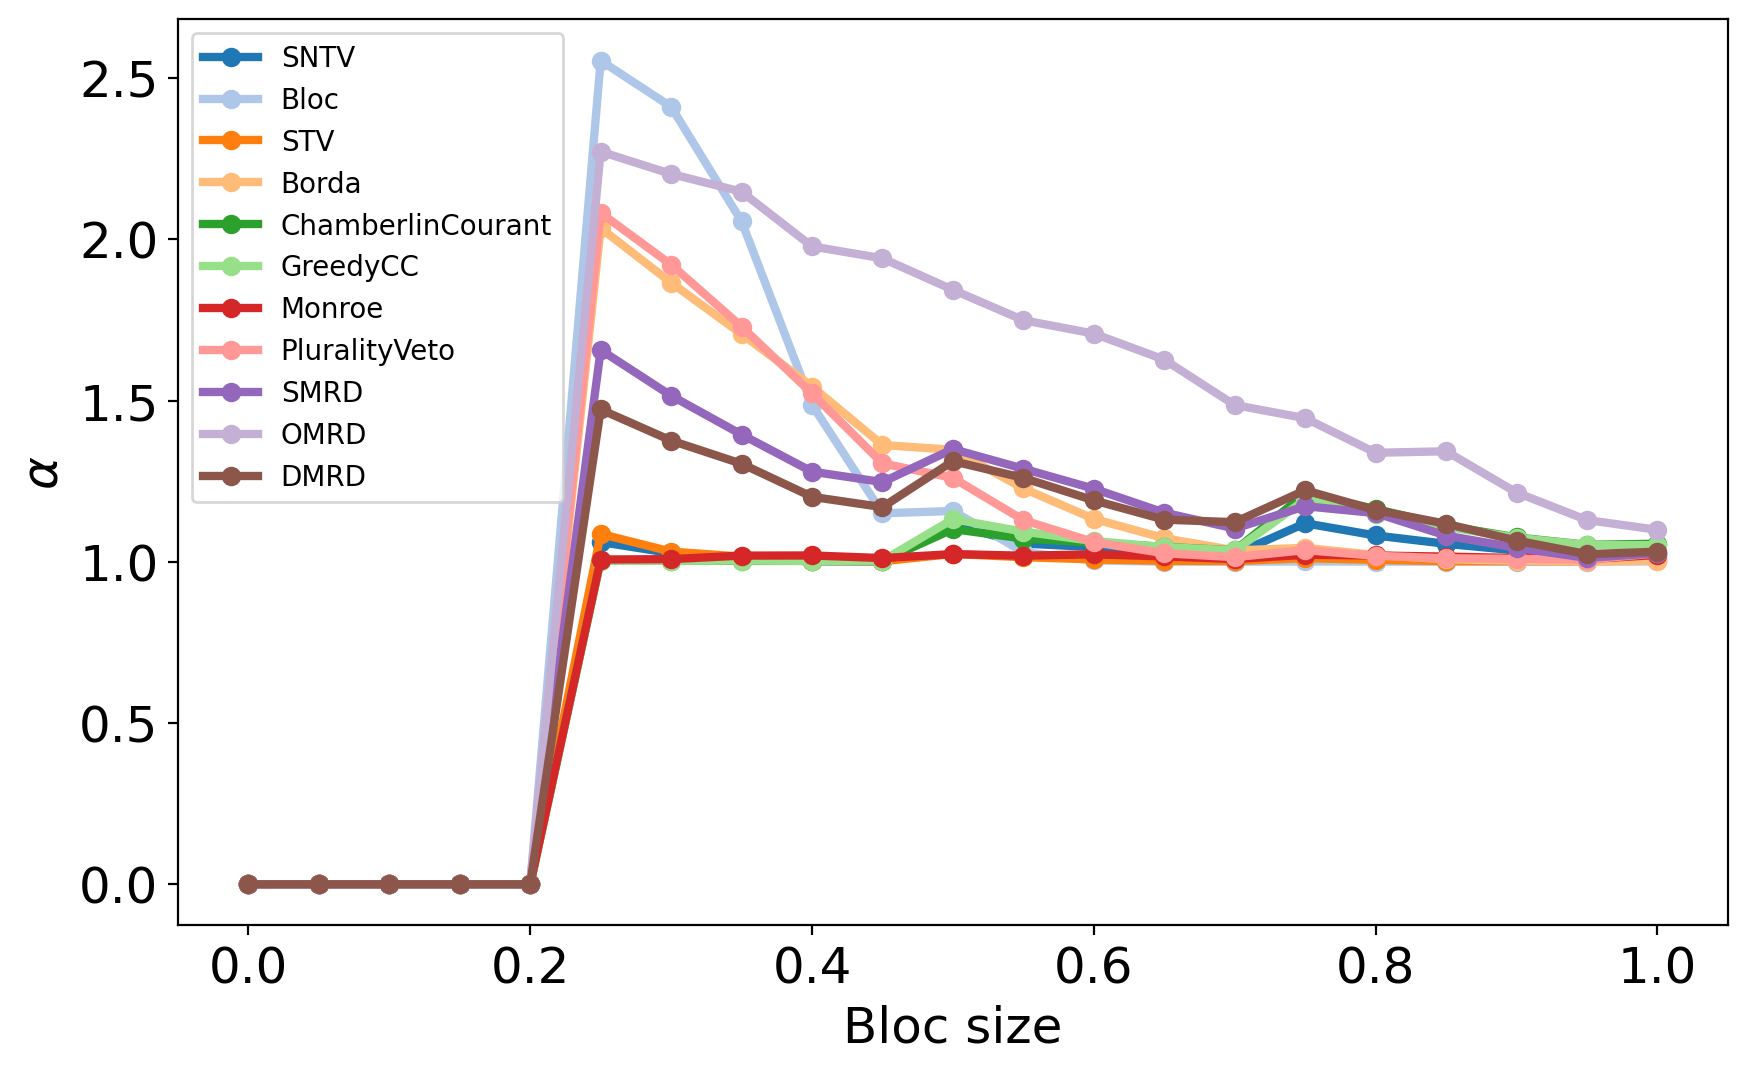

In [64]:
plt.rcParams.update({'font.size': 18})
tab20_colors = plt.cm.tab20.colors

fig,ax = plt.subplots(figsize=(10, 6), dpi = 200)

Asizes = [x[group_select]/100 for x in group_sizes]
for i, (ename,evals) in enumerate(size_avg_represent.items()):
    ax.plot(Asizes, evals[0], label=ename, color = tab20_colors[i], linewidth = 3, marker = 'o')
    #ax.fill_between(Asizes, evals[0] - evals[1], evals[0] + evals[1], color=tab20_colors[i], alpha=0.05)

plt.ylabel(r'$\alpha$')
plt.xlabel('Bloc size')
plt.legend(fontsize = 10, loc = 'upper left')
plt.savefig('figures/2party_sizes.png', bbox_inches='tight')
plt.show()

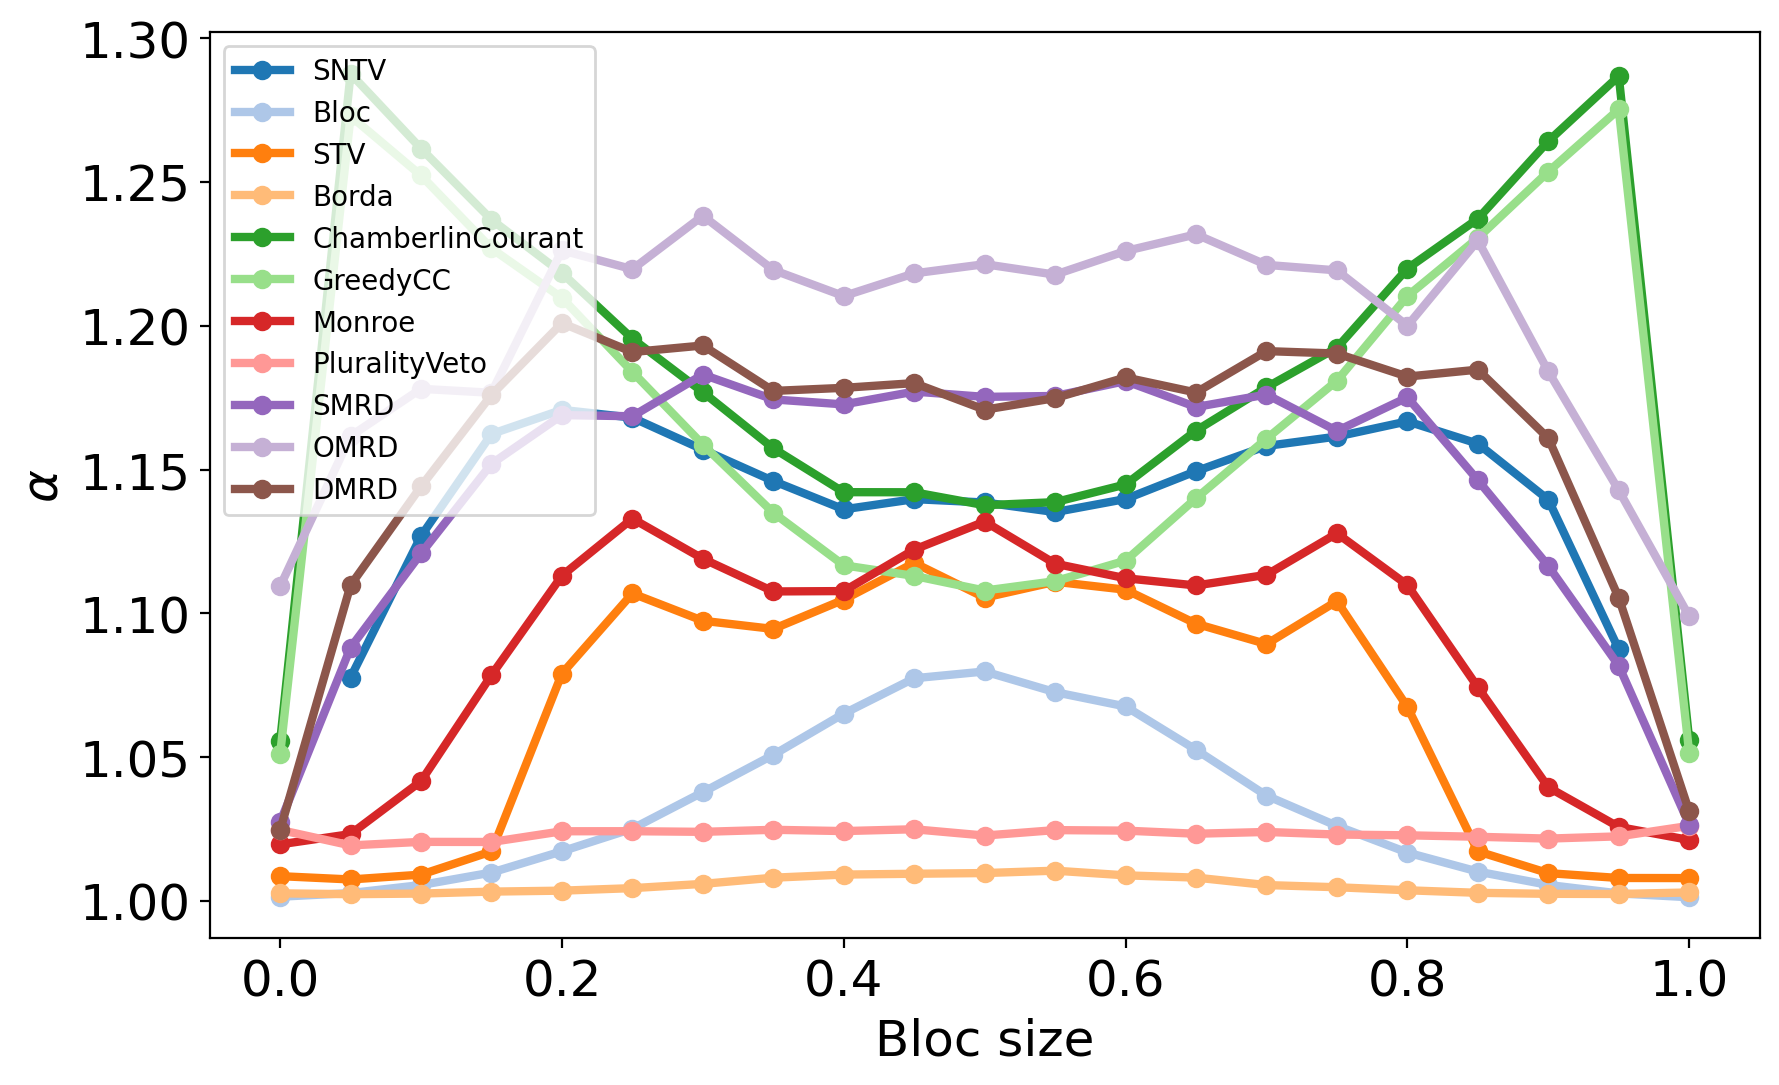

In [66]:
plt.rcParams.update({'font.size': 18})
tab20_colors = plt.cm.tab20.colors

fig,ax = plt.subplots(figsize=(10, 6), dpi = 200)

Asizes = [x[group_select]/100 for x in group_sizes]
for i, (ename,evals) in enumerate(size_avg_represent1.items()):
    ax.plot(Asizes, evals[0], label=ename, color = tab20_colors[i], linewidth = 3, marker = 'o')
    #ax.fill_between(Asizes, evals[0] - evals[1], evals[0] + evals[1], color=tab20_colors[i], alpha=0.05)

plt.ylabel(r'$\alpha$')
plt.xlabel('Bloc size')
plt.legend(fontsize = 10, loc = 'upper left')
plt.savefig('figures/2party_sizes1.png', bbox_inches='tight')
plt.show()